In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [3]:
## loading training set
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/Wafa/Documents/MINIPROJECT/data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 791 files belonging to 2 classes.


In [4]:
## loading validation dataset
validation_data =  tf.keras.preprocessing.image_dataset_from_directory(
    'D:/Wafa/Documents/MINIPROJECT/data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 98 files belonging to 2 classes.


In [5]:
## loading testing dataset
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/Wafa/Documents/MINIPROJECT/data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 100 files belonging to 2 classes.


In [6]:
class_names = training_data.class_names
class_names

['Accident', 'Non Accident']

In [7]:
# Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Load ResNet50 model 
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the weights of the pre-trained layers
for layer in resnet_base.layers[:-10]:  
    layer.trainable = False

# Add new classification layers on top
x = Flatten()(resnet_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
output = Dense(len(class_names), activation='softmax')(x)  

model2 = Model(inputs=resnet_base.input, outputs=output)

# Specify learning rate separately
learning_rate = 0.0001

# Create Adam optimizer with specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with a lower initial learning rate
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Define the filepath for saving model weights
filepath = "model2.weights.h5"

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

# Learning rate scheduling
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-7)

# List of callbacks
callbacks_list = [checkpoint, lr_scheduler]

In [10]:
# Train the model on your dataset
history = model2.fit(training_data, validation_data=validation_data, epochs=20, callbacks=callbacks_list)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6094 - loss: 4.8272
Epoch 1: val_accuracy improved from -inf to 0.77551, saving model to model2.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - accuracy: 0.6157 - loss: 4.7462 - val_accuracy: 0.7755 - val_loss: 0.8337 - learning_rate: 1.0000e-04
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8427 - loss: 0.9767
Epoch 2: val_accuracy improved from 0.77551 to 0.92857, saving model to model2.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - accuracy: 0.8436 - loss: 0.9576 - val_accuracy: 0.9286 - val_loss: 0.2270 - learning_rate: 1.0000e-04
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9296 - loss: 0.2285
Epoch 3: val_accuracy did not improve from 0.92857
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - accuracy: 0.9292 - loss: 0.2321 - val_accuracy: 0.9082 - val_loss: 0.3686 - learning_rate: 1.0000e-04
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9508 - loss: 0.1550
Epoch 4: val_accuracy did

In [11]:
# Save model architecture as JSON file
model2_json = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model2_json)

In [12]:
import matplotlib.pyplot as plt

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


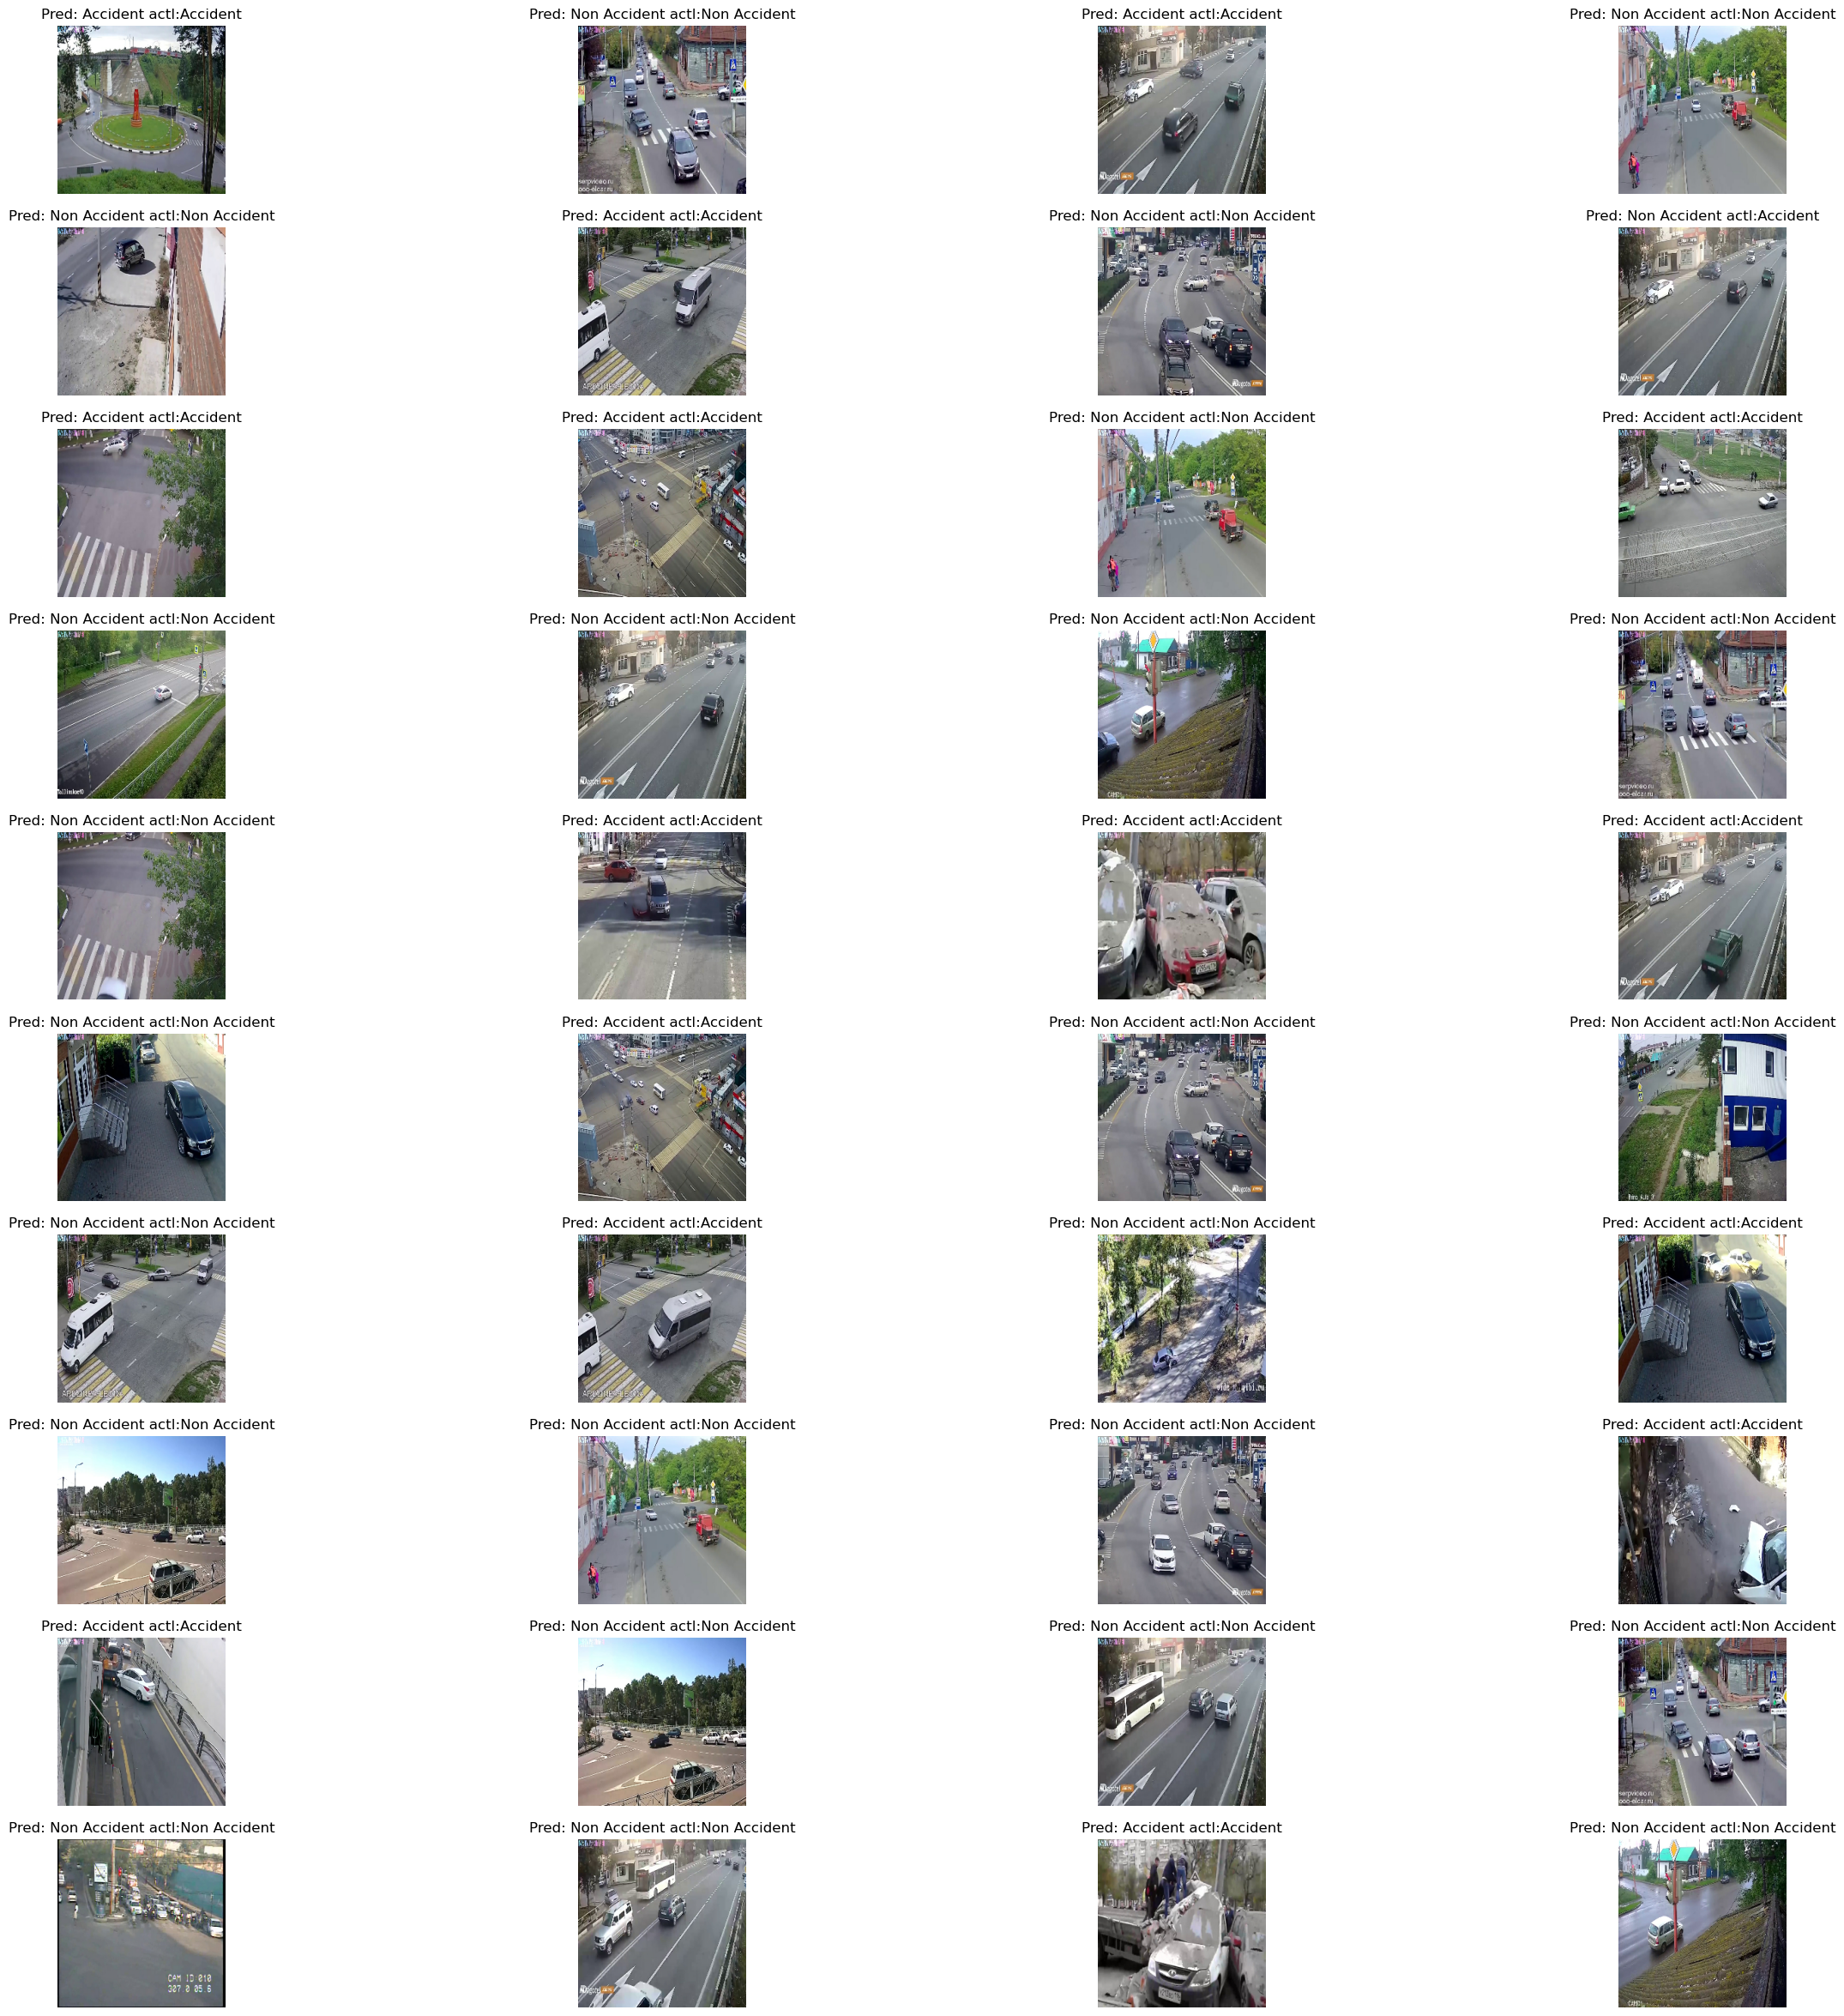

In [13]:
## lets vizualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_data.take(1):
    predictions = model2.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)